# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>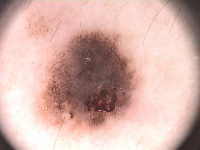</td><td>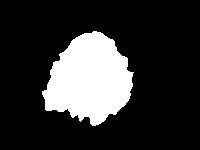</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [2]:
! wget https://www.dropbox.com/s/697ua96yvw4gj0z/PH2Dataset.rar

--2020-05-31 16:19:09--  https://www.dropbox.com/s/697ua96yvw4gj0z/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/697ua96yvw4gj0z/PH2Dataset.rar [following]
--2020-05-31 16:19:09--  https://www.dropbox.com/s/raw/697ua96yvw4gj0z/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3d9c2080ebf56d9acb8b4e1f82.dl.dropboxusercontent.com/cd/0/inline/A4xbO06yxPKiiw9JP93BIVJ7TRvsQg-3kXaJ6MN0vCMI_Dcv1Mj004pS5SnfUjDyH7vjGRfahjDkUqbkuzfTZ2GryP4wkj6vQF1yfXnqtBUEbUODSqcCIg-JK5mPxtwk9YE/file# [following]
--2020-05-31 16:19:09--  https://uc3d9c2080ebf56d9acb8b4e1f82.dl.dropboxusercontent.com/cd/0/inline/A4xbO06yxPKiiw9JP93BIVJ7TRvsQg-3kXaJ6MN0vCMI_Dcv1Mj004pS5SnfUjDyH7vjGRfahjDkUqbkuzfTZ2GryP4wkj6vQF1yfXnqt

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [0]:
import random
import numpy as np
import torch
from copy import deepcopy
from torch.optim import lr_scheduler
from torchvision import transforms
random.seed(42)
torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.determenistic = True
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

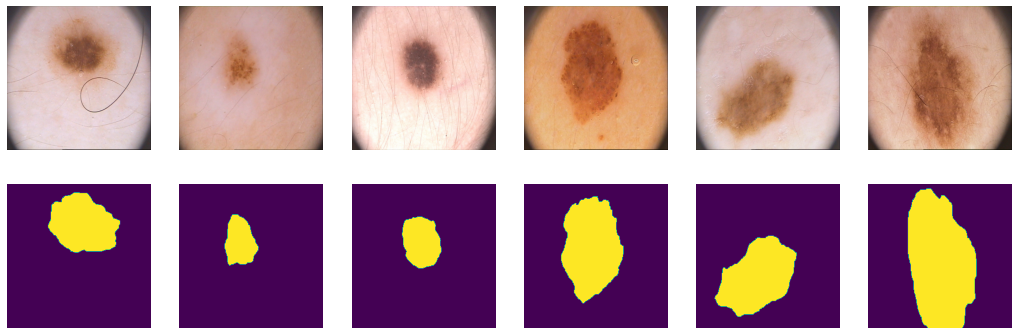

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

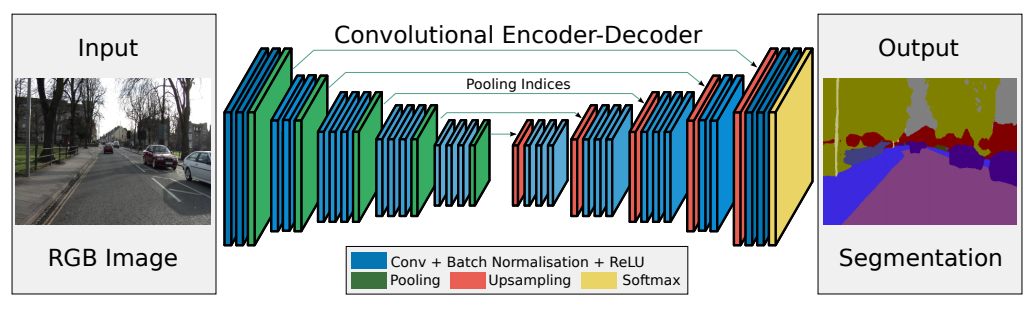

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
random.seed(42)
torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.determenistic = True
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, return_indices = True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, return_indices = True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, return_indices = True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

        # bottleneck
        #self.bottleneck_conv = nn.Conv2d(in_channels= 256, out_channels = 256, kernel_size = 3, padding = 1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample1 =  nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 3, padding = 1),
        )
    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0[0]))
        e2 = self.pool2(self.enc_conv2(e1[0]))
        e3 = self.pool3(self.enc_conv3(e2[0]))
        # bottleneck
        #b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3[0], e3[1]))
        d1 = self.dec_conv1(self.upsample1(d0, e2[1]))
        d2 = self.dec_conv2(self.upsample2(d1, e1[1]))
        d3 = self.dec_conv3(self.upsample3(d2, e0[1]))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    L_BCE = (torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred)))).mean()
    return L_BCE

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    avg_loss = 0
    scheduler.step()
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(labels, outputs)
        loss.backward()
        optimizer.step()
        avg_loss += loss / len(train_loader)
    train_score = score_model(model, iou_pytorch, train_loader)
    return avg_loss.item(), train_score

In [0]:
def eval_epoch(model, val_loader, criterion, test = False):
    model.eval()
    avg_loss = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(labels, outputs)
        avg_loss += loss / len(val_loader)
    global best_score, best_model_wts
    val_score = score_model(model, iou_pytorch, val_loader)
    if val_score > best_score and not test:
        best_score = val_score
        best_model_wts = model.state_dict()
    return avg_loss.item(), val_score

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    global best_score, best_model_wts
    best_model_wts = model.state_dict()
    best_score = 0.0
    history = []
    scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)
    for epoch in range(epochs):
        train_loss, train_score = fit_epoch(model, data_tr, loss_fn, opt, scheduler)
        val_loss, val_score = eval_epoch(model, data_val, loss_fn)
        test_loss, test_score = eval_epoch(model, data_ts, loss_fn, test = True)
        history.append([train_loss, train_score, val_loss, val_score, test_loss, test_score])
        #print("train_loss:{},".format(train_loss), 'train_score:{},'.format(train_score), 'val_loss:{},'.format(val_loss), 'val_score:{},'.format(val_score))
        clear_output(wait=True)
        Y_hat = model(X_val.to(device)).detach().cpu() > 0.5
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
    history = np.array(history)
    model.load_state_dict(best_model_wts)
    return history, model

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)) > 0
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [0]:
def get_plot(history, loss, net):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(history) + 1), history[:, 0], label = 'train_loss')
    ax.plot(range(1, len(history) + 1), history[:, 1], label = 'train_score')
    ax.plot(range(1, len(history) + 1), history[:, 2], label = 'val_loss')
    ax.plot(range(1, len(history) + 1), history[:, 3], label = 'val_score')
    ax.plot(range(1, len(history) + 1), history[:, 4], label = 'test_loss')
    ax.plot(range(1, len(history) + 1), history[:, 5], label = 'test_score')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Net:{}   Loss:{}'.format(net, loss))
    plt.show()

## Основной момент: обучение

In [0]:
model = SegNet()
model = model.to(device)

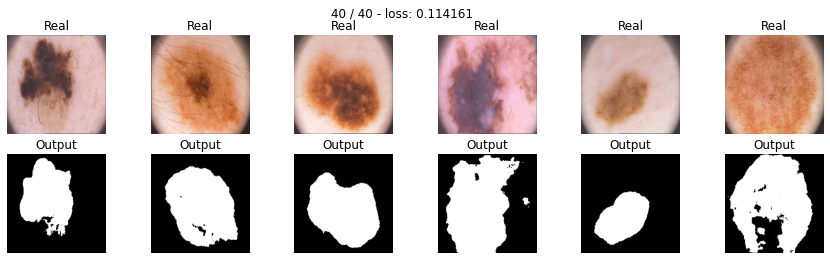

In [25]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters())
history1, model1 = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

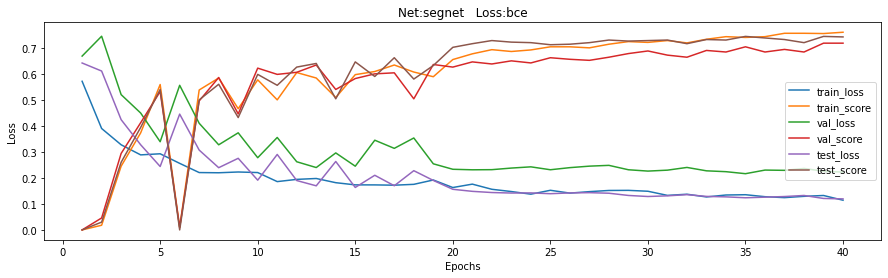

In [26]:
get_plot(history1, 'bce', 'segnet')

In [75]:
score_model(model1, iou_pytorch, data_val)

0.7180000424385071

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred, eps = 1e-8):
    y_pred = torch.sigmoid(y_pred)

    num = (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 2 * ((num + eps)/ (den + eps))
    return res 

Проводим тестирование:

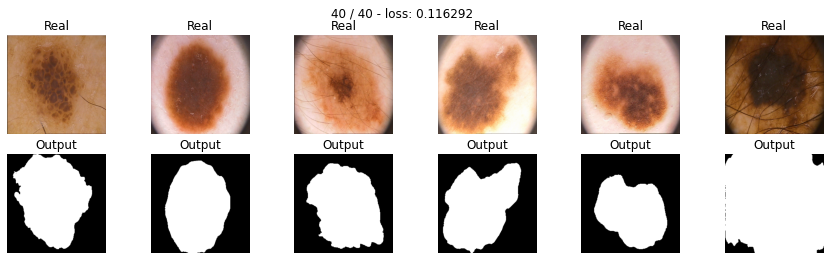

In [29]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
history2, model2 = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

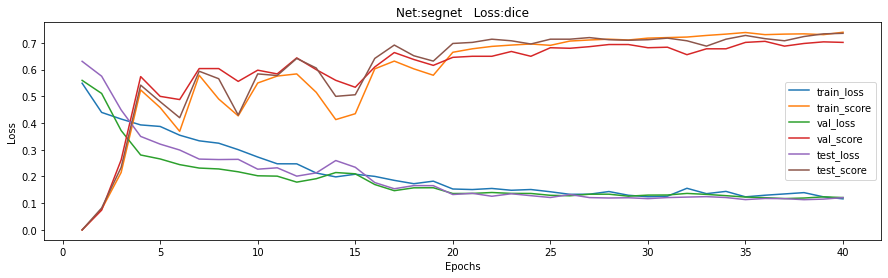

In [30]:
get_plot(history2, 'dice', 'segnet')

In [76]:
score_model(model2, iou_pytorch, data_val)

0.7020000457763672

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss_1(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    your_loss =   -((1 - y_pred) ** gamma * y_real * torch.log(y_pred + eps) 
                     + (1-y_real)*torch.log(1-y_pred + eps)).mean()
    return your_loss


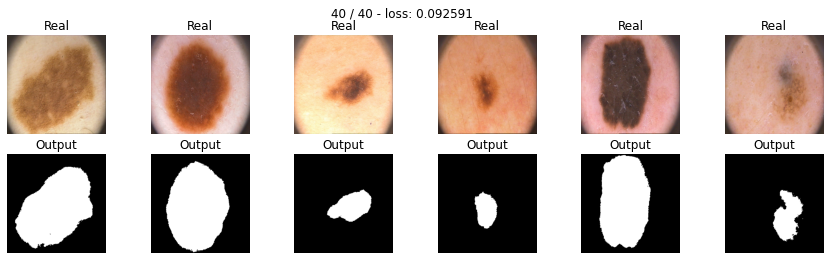

In [33]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters())
history3, model3 = train(model_focal, optimaizer, focal_loss_1, max_epochs, data_tr, data_val)

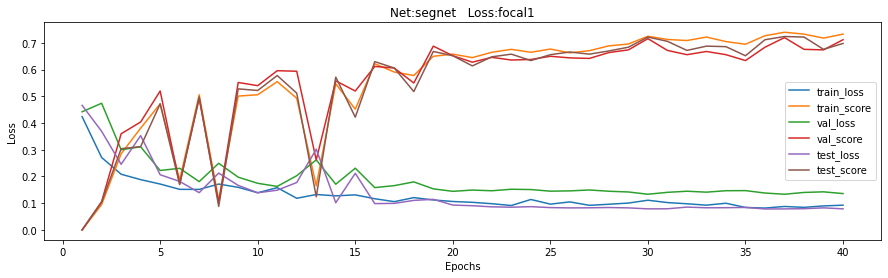

In [34]:
get_plot(history3, 'focal1', 'segnet')

In [77]:
score_model(model3, iou_pytorch, data_val)

0.7120000123977661

In [0]:
def focal_loss_2(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    your_loss =   -((1 - y_pred) ** gamma * y_real * torch.log(y_pred + eps) 
                     + y_pred ** gamma *(1-y_real)*torch.log(1-y_pred + eps)).mean()
    return your_loss

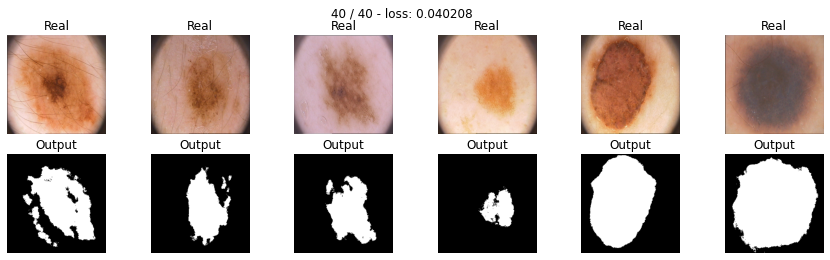

In [37]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters())
history4, model4 = train(model_focal, optimaizer, focal_loss_2, max_epochs, data_tr, data_val)

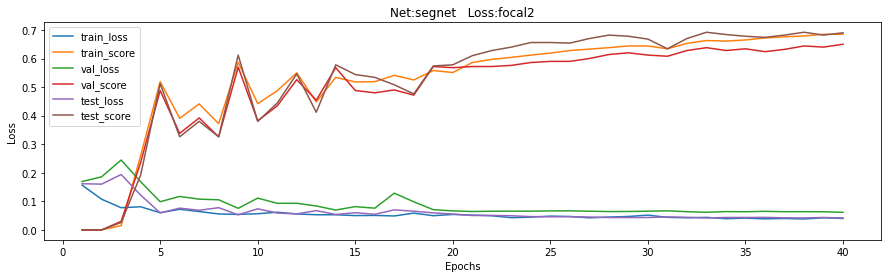

In [38]:
get_plot(history4, 'focal2', 'segnet')

In [78]:
score_model(model4, iou_pytorch, data_val)

0.6500000357627869

In [0]:
def focal_loss_3(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    your_loss =   -(y_real * torch.log(y_pred + eps) 
                     + y_pred ** gamma *(1-y_real)*torch.log(1-y_pred + eps)).mean()
    return your_loss

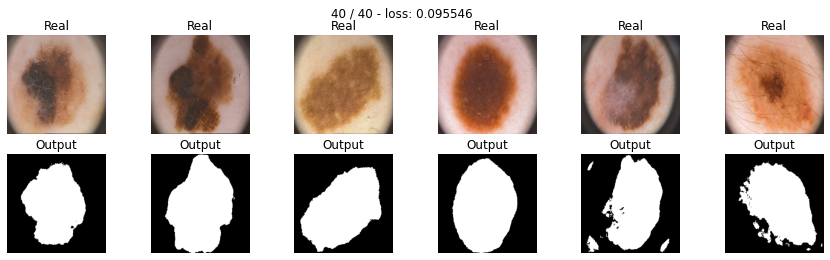

In [41]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters())
history5, model5 = train(model_focal, optimaizer, focal_loss_3, max_epochs, data_tr, data_val)

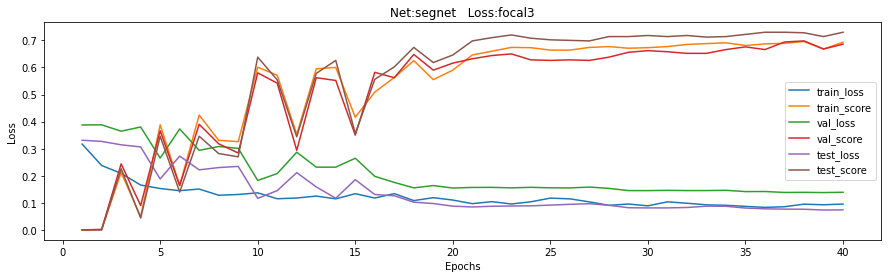

In [42]:
get_plot(history5, 'focal3', 'segnet')

In [79]:
score_model(model5, iou_pytorch, data_val)

0.6860000371932984

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, eps = 1e-8, alpha = 0.7):
    y_pred = torch.sigmoid(y_pred)
    TP = (y_real * y_pred).sum()
    FP = ((1 - y_real)*y_pred).sum()
    FN = (y_real * (1-y_pred)).sum()
    den = TP + alpha * FN + (1-alpha) * FP
    res = 1 - (TP + 1) / (den + 1) 
    return res 

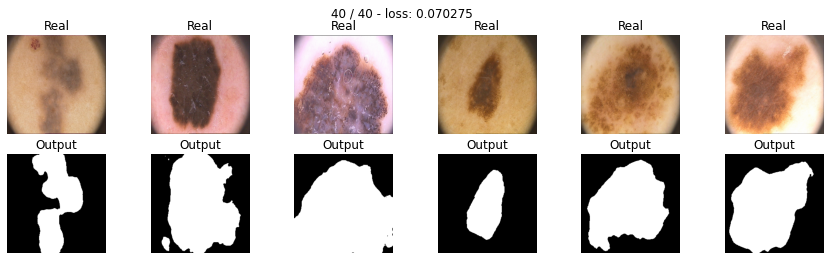

In [45]:
model = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model.parameters())
history6, model6 = train(model, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

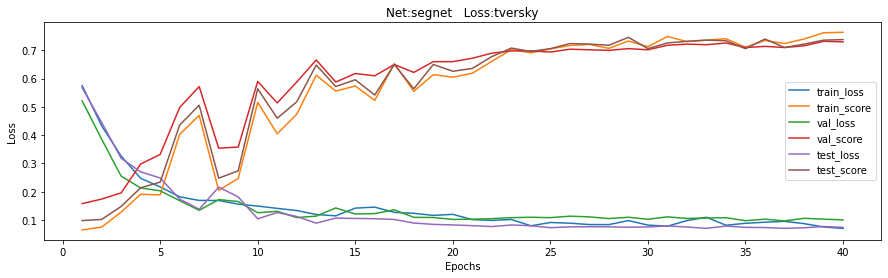

In [46]:
get_plot(history6, 'tversky', 'segnet')

In [74]:
score_model(model6, iou_pytorch, data_val)

0.7300000309944152

На валидации tversky_loss показывает наилучший результат:0.73, в то время как bce:0.718, dice:0.702, focal1:0.72, также по графикам можно заметить что tversky loss ведет себя плавнее на валидации и не сильно отличается от лосса на трейне, чем например на bce 

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

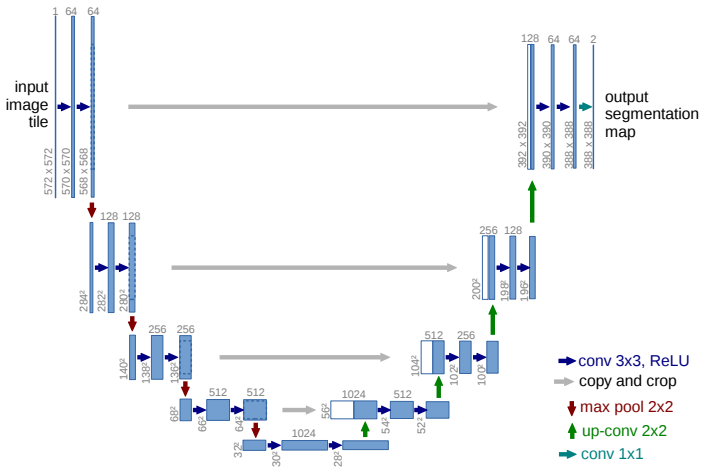

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
random.seed(42)
torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.determenistic = True
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(                          # 16 -> 32
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1)
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Sequential(                          # 32 -> 64
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1)
        ) 
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Sequential(                          # 64 -> 128
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        )   
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Sequential(                          # 128 -> 256
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        )     
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.enc_conv3(e2), self.upsample0(b)), dim = 1))
        d1 = self.dec_conv1(torch.cat((self.enc_conv2(e1), self.upsample1(d0)), dim = 1))
        d2 = self.dec_conv2(torch.cat((self.enc_conv1(e0), self.upsample2(d1)), dim = 1))
        d3 = self.dec_conv3(torch.cat((self.enc_conv0(x), self.upsample3(d2)), dim = 1))  # no activation
        return d3

In [0]:
unet_model = UNet().to(device)

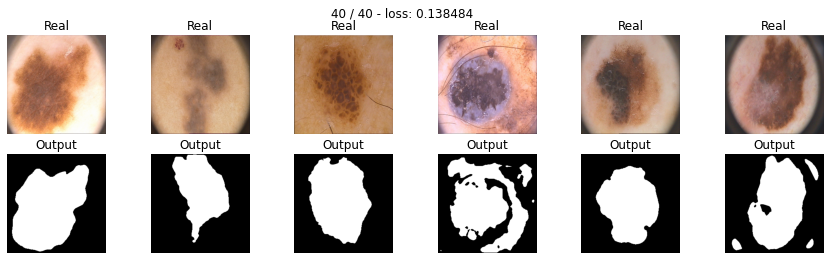

In [50]:
history7, model7 = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 40, data_tr, data_val)

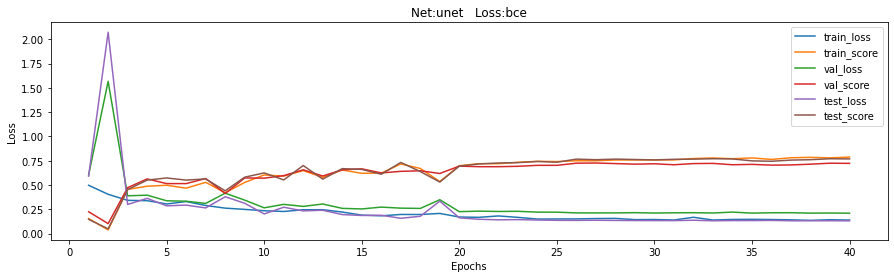

In [51]:
get_plot(history7, 'bce', 'unet')

In [80]:
score_model(model7, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7220000147819519

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
random.seed(42)
torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.determenistic = True
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 2, padding = 1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 2, padding = 1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
                    # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 =  nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
             # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 =   nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2)

        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.enc_conv3(e2), self.upsample0(b)), dim = 1))
        d1 = self.dec_conv1(torch.cat((self.enc_conv2(e1), self.upsample1(d0)), dim = 1))
        d2 = self.dec_conv2(torch.cat((self.enc_conv1(e0), self.upsample2(d1)), dim = 1))
        d3 = self.dec_conv3(torch.cat((self.enc_conv0(x), self.upsample3(d2)), dim = 1))  # no activation
        return d3

In [0]:
unet2_model = UNet2().to(device)


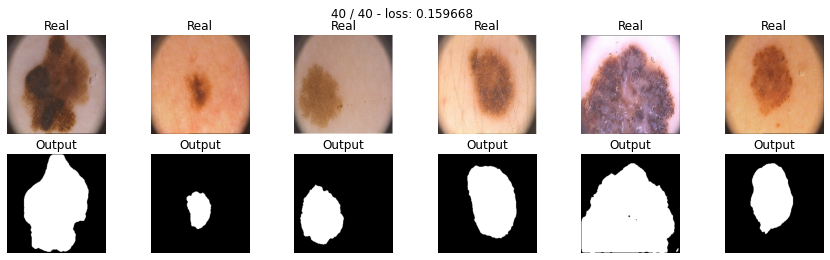

In [55]:
history8, model8= train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, 40, data_tr, data_val)

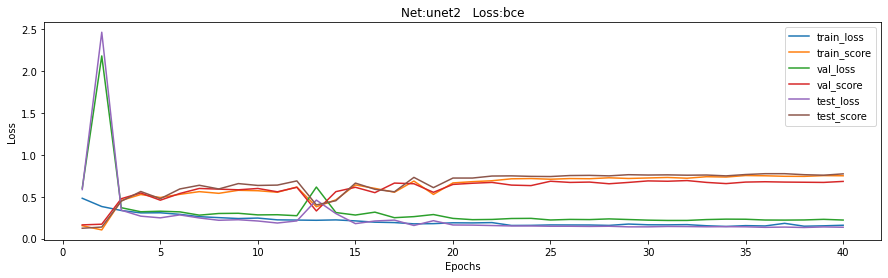

In [56]:
get_plot(history8, 'bce', 'unet2')

In [81]:
score_model(model8, iou_pytorch, data_val)

0.6820000410079956

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
random.seed(42)
torch.manual_seed(42) 
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.determenistic = True
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, dilation = 64)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, dilation = 32) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, dilation = 16) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, dilation = 8) # 32 -> 16
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, dilation = 8)                          # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, dilation = 16)                          # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, dilation = 32)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, dilation = 64)
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        
        b = self.bottleneck_conv(e3)
        d0 = self.dec_conv0(torch.cat((self.enc_conv3(e2), self.upsample0(b)), dim = 1))
        d1 = self.dec_conv1(torch.cat((self.enc_conv2(e1), self.upsample1(d0)), dim = 1))
        d2 = self.dec_conv2(torch.cat((self.enc_conv1(e0), self.upsample2(d1)), dim = 1))
        d3 = self.dec_conv3(torch.cat((self.enc_conv0(x), self.upsample3(d2)), dim = 1))  # no activation
        return d3

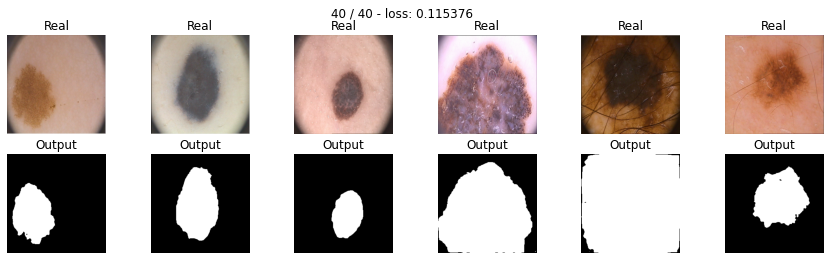

In [59]:
model = DilatedSegNet().to(device)
history9, model9 = train(model, torch.optim.Adam(model.parameters()), bce_loss, 40, data_tr, data_val)

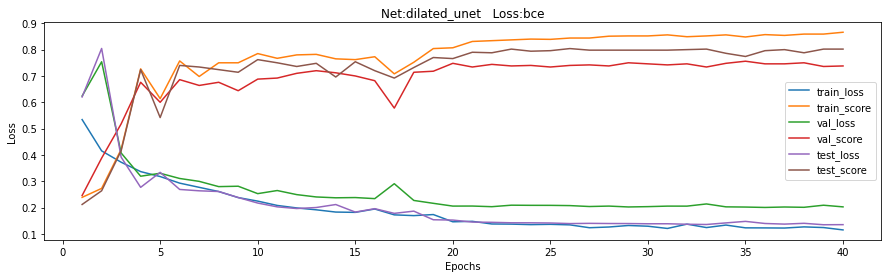

In [60]:
get_plot(history9, 'bce', 'dilated_unet')

In [82]:
score_model(model9, iou_pytorch, data_val)

0.7380000233650208

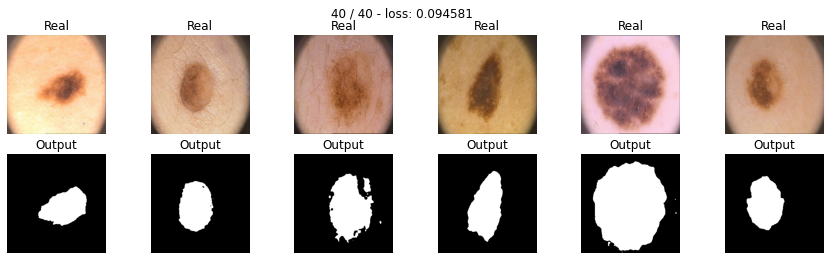

In [66]:
model = DilatedSegNet().to(device)
history11, model11 = train(model, torch.optim.Adam(model.parameters()), dice_loss, 40, data_tr, data_val)

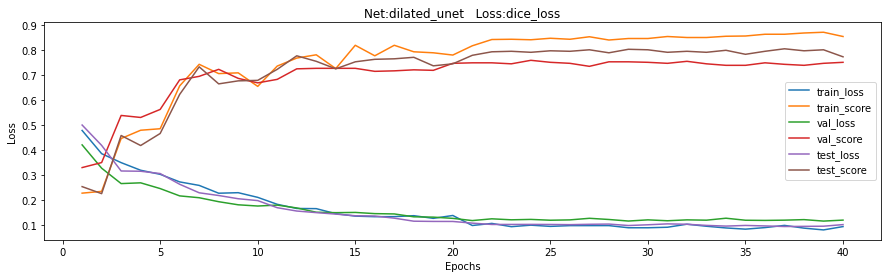

In [67]:
get_plot(history11, 'dice_loss', 'dilated_unet')

In [83]:
score_model(model11, iou_pytorch, data_val)

0.7500000357627868

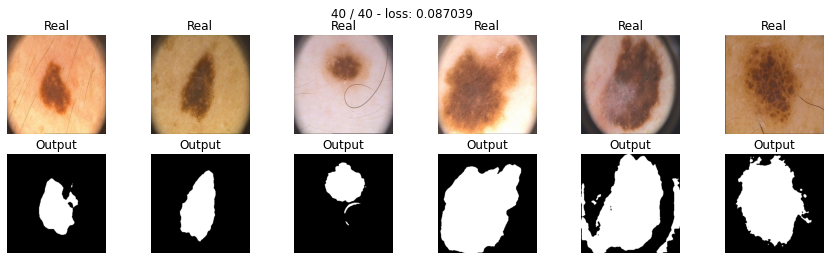

In [65]:
model = DilatedSegNet().to(device)
history10, model10 = train(model, torch.optim.Adam(model.parameters()), tversky_loss, 40, data_tr, data_val)

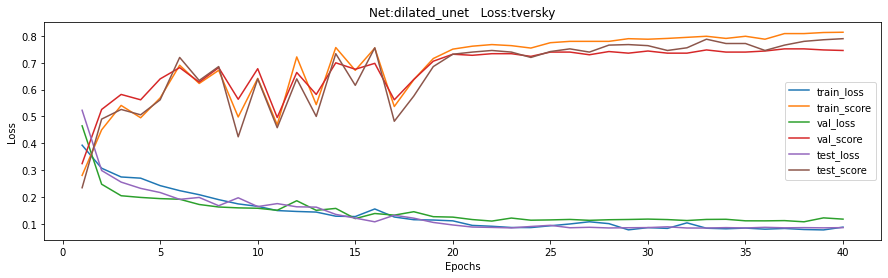

In [72]:
get_plot(history10, 'tversky', 'dilated_unet')

In [84]:
score_model(model10, iou_pytorch, data_val)

0.7460000157356262

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



В данной работе было исследовано две архитектуры нейросети:segnet и unet. Ниже представлены графики для лоссов, метрик на трейне, валидации и тесте для segnet и unet для функции потерь bce

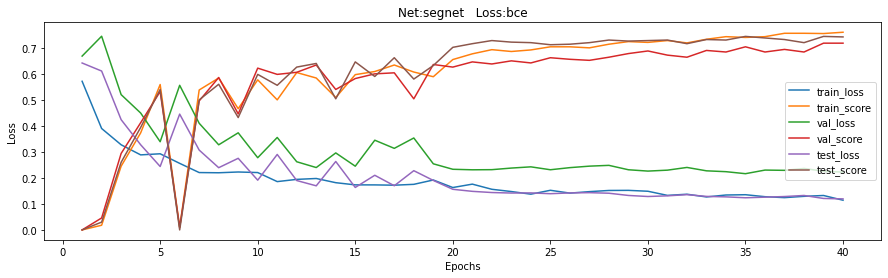

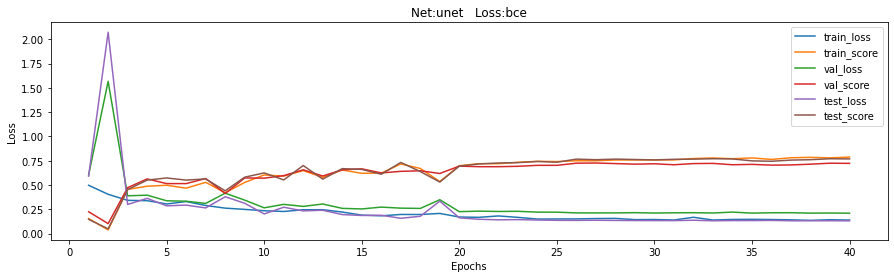

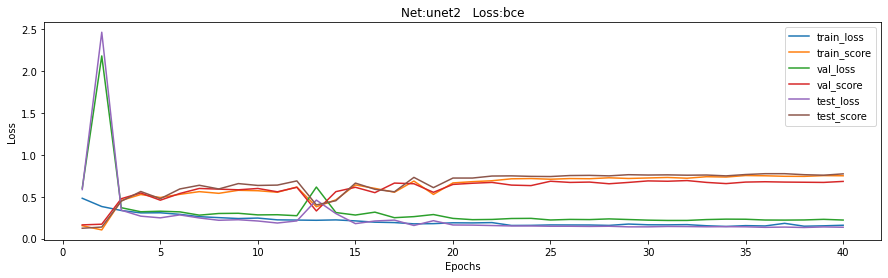

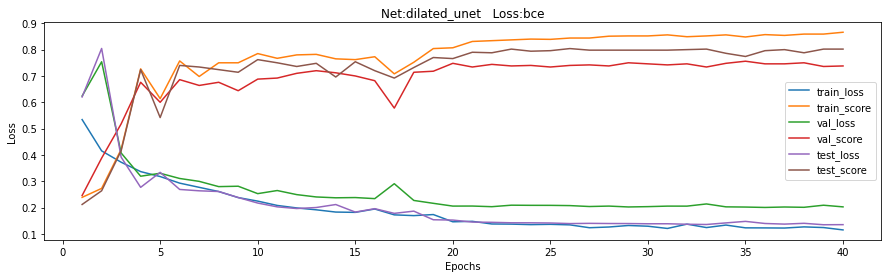

In [85]:
get_plot(history1, 'bce', 'segnet')
get_plot(history7, 'bce', 'unet')
get_plot(history8, 'bce', 'unet2')
get_plot(history9, 'bce', 'dilated_unet')

Если взглянуть на результат на валидации, то лучше всего результат при архитектуре unet с dilated слоями:0.738, при этом функция потерь ведет себя более плавно, чем на других архитектурах и наблюдается лучшая сходимость.Ниже представлены графики для dilated unet с tversky loss и dice лосс.

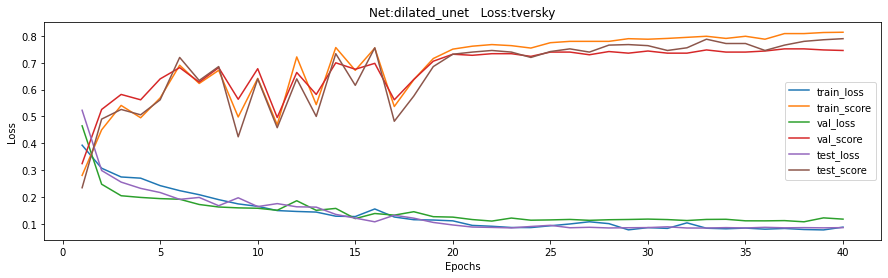

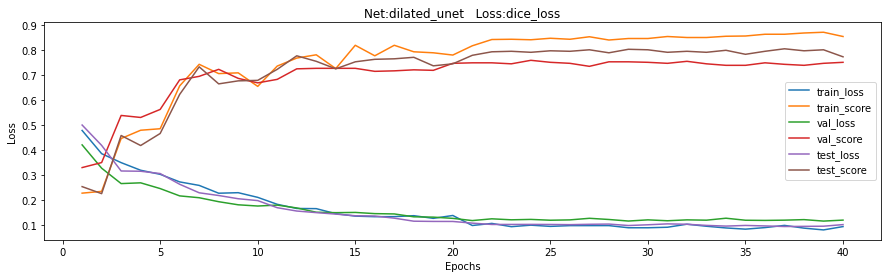

In [86]:
get_plot(history10, 'tversky', 'dilated_unet')
get_plot(history11, 'dice_loss', 'dilated_unet')

По графикам видно, что при dice loss скор сильнее отличается на трейне от валидации чем на tversky, это может говорить о начале переобучения при dice loss, плюс интерпретируемость результата не так очевидна в данном случае, поэтому в качестве лучшей архитектуры мной была выбрана dilated unet с tversky loss. Скор на тесте при данной архитектуре равен:

In [87]:
score_model(model10, iou_pytorch, data_ts)

0.790000033378601